In [14]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

from recycle_cnn import CNN
from recycle_resnet import ResNet, BasicBlock
from collections import Counter


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)
    
learning_rate = 0.0000003
epochs = 25
batch_size = 32

In [16]:
trans = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
train_set = torchvision.datasets.ImageFolder('binary_data/train', transform=trans)

aug_trans1 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])
aug_trans2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])
aug_train_set1 = torchvision.datasets.ImageFolder('binary_data/train', transform=aug_trans1)
aug_train_set2 = torchvision.datasets.ImageFolder('binary_data/train', transform=aug_trans2)

train_all_set = torch.utils.data.ConcatDataset([train_set, aug_train_set1, aug_train_set2])

total = len(train_set)
class_weights = [0] * 6
sample_weights = [0] * len(train_all_set)
for k, i in dict(Counter(train_set.targets)).items():
    class_weights[k] = (total - i) / total
for idx, (data, label) in enumerate(train_all_set):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_all_set, batch_size=batch_size, sampler=sampler)


In [17]:
valid_set = torchvision.datasets.ImageFolder('binary_data/test',transform=trans)
valid_loader = DataLoader(valid_set)

In [18]:
# model = CNN().to(device)
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

In [19]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

total_batch = len(train_loader)


In [20]:
print(model)

ResNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [21]:
classes = train_set.classes

In [22]:
def train_one_epoch(data_loader):
    model.train()
    running_loss = 0
    total = 0
    correct = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.max(outputs, 1)[1]
        correct += (preds == labels).sum()
        total += len(labels)
        running_loss += loss.detach()
        
    loss = (running_loss / len(data_loader)).item()
    accuracy = (correct * 100 / total).item()
    return loss, accuracy


In [23]:
best_valid_acc = 0

def eval_one_epoch(data_loader):
    global best_valid_acc
    
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model.eval()
    running_loss = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.max(outputs, 1)[1]
            correct += (preds == labels).sum()
            
            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            total += len(labels)
            running_loss += loss.detach()
        
        loss = (running_loss / len(data_loader)).item()
        accuracy = (correct * 100 / total).item()
        if accuracy > best_valid_acc:
            torch.save(model, 'best_model.pt')
        return loss, accuracy, correct_pred, total_pred

In [24]:
train_loss_hist = []
train_acc_hist = []
valid_loss_hist = []
valid_acc_hist = [] 
valid_class_acc_hist = {classname: [] for classname in classes}

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    valid_loss, valid_acc, correct_pred, total_pred = eval_one_epoch(valid_loader)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    print(f"Epoch: {epoch}\nTrain Loss: {train_loss_hist[-1]}, accuracy: {train_acc_hist[-1]}\n"+
        f"Valid loss: {valid_loss_hist[-1]}, accuracy: {valid_acc_hist[-1]}")
    
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        valid_class_acc_hist[classname].append(accuracy)
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Epoch: 0
Train Loss: 1.4760273694992065, accuracy: 58.41284942626953
Valid loss: 1.4691694974899292, accuracy: 49.18793487548828
Accuracy for class: recycle is 45.9 %
Accuracy for class: trash is 93.3 %
Epoch: 1
Train Loss: 1.2402379512786865, accuracy: 70.00636291503906
Valid loss: 1.236406683921814, accuracy: 59.164730072021484
Accuracy for class: recycle is 56.6 %
Accuracy for class: trash is 93.3 %
Epoch: 2
Train Loss: 1.036799430847168, accuracy: 73.99809265136719
Valid loss: 1.071684718132019, accuracy: 61.71693420410156
Accuracy for class: recycle is 59.9 %
Accuracy for class: trash is 86.7 %
Epoch: 3
Train Loss: 0.8918527364730835, accuracy: 76.73345947265625
Valid loss: 0.9616207480430603, accuracy: 65.89327239990234
Accuracy for class: recycle is 64.3 %
Accuracy for class: trash is 86.7 %
Epoch: 4
Train Loss: 0.7898706793785095, accuracy: 78.73727416992188
Valid loss: 0.8146937489509583, accuracy: 74.013916015625
Accuracy for class: recycle is 73.1 %
Accuracy for class: trash

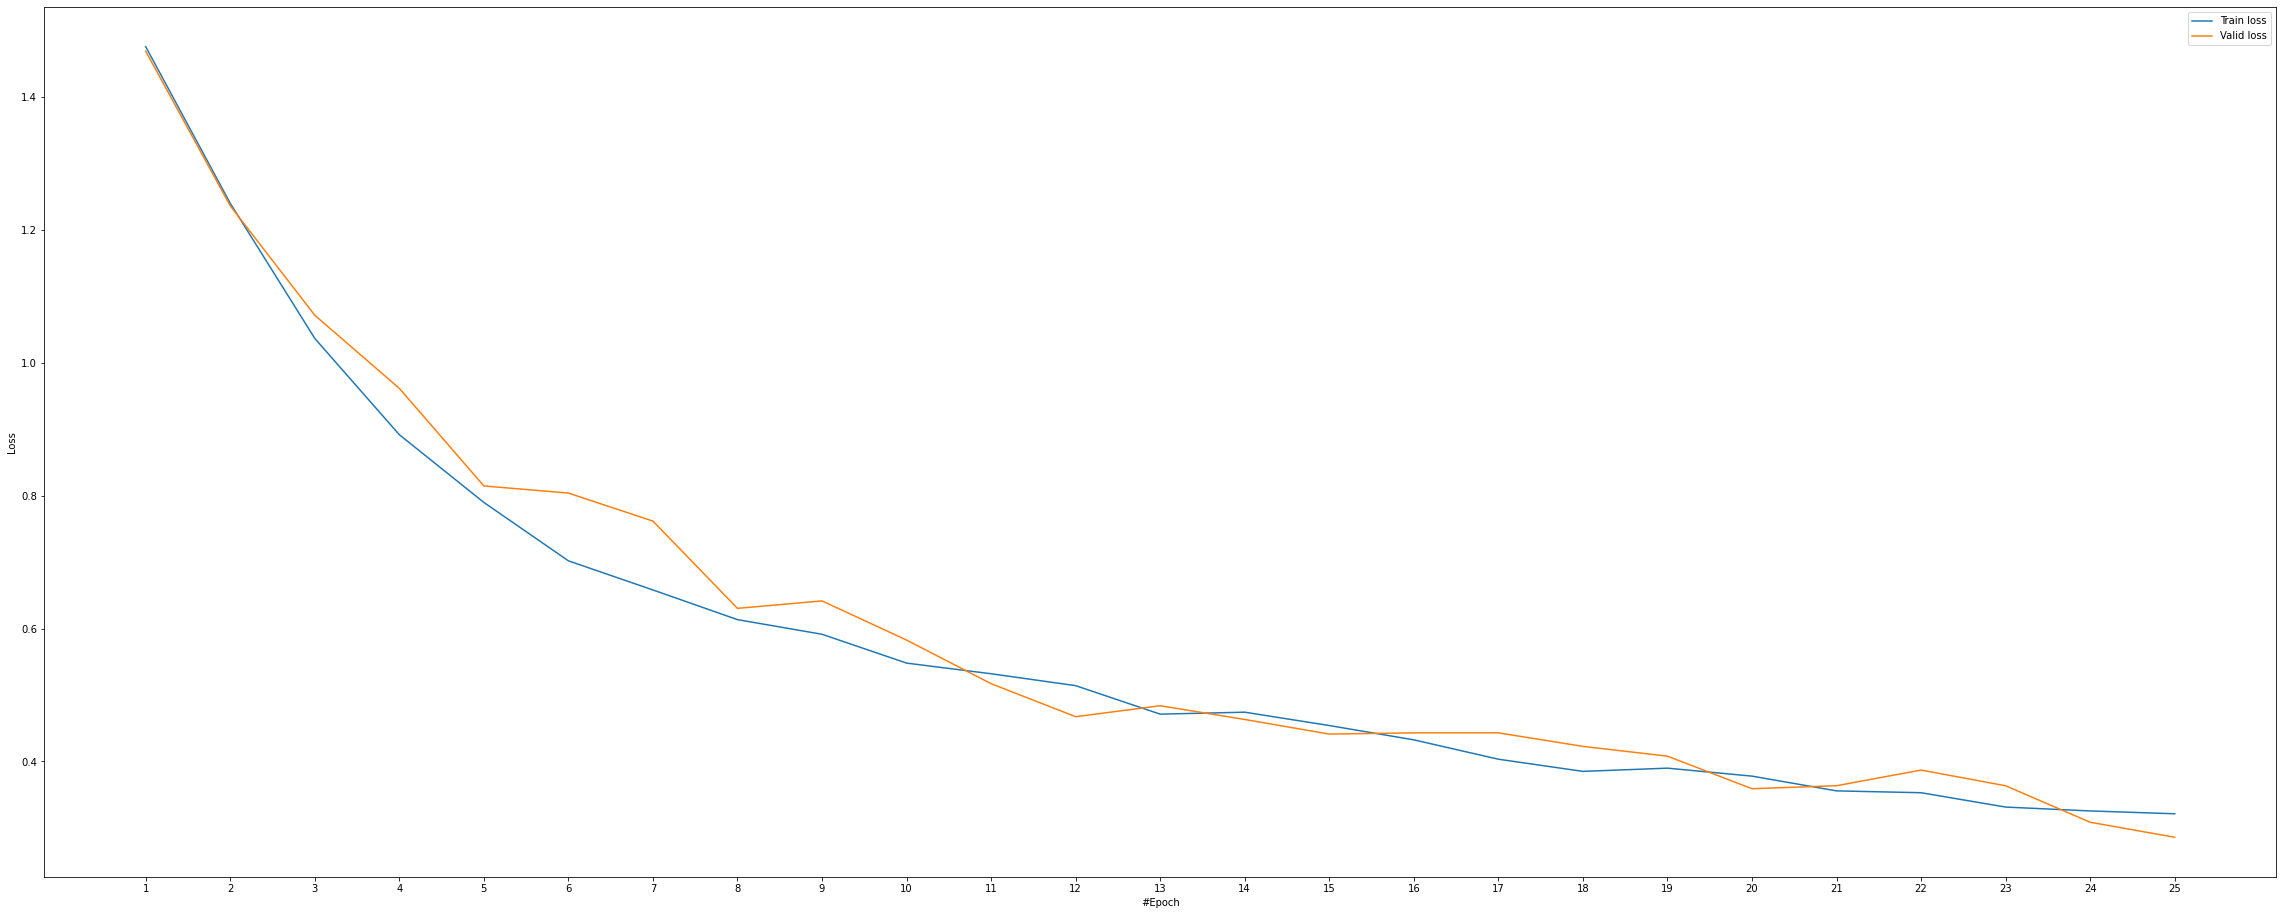

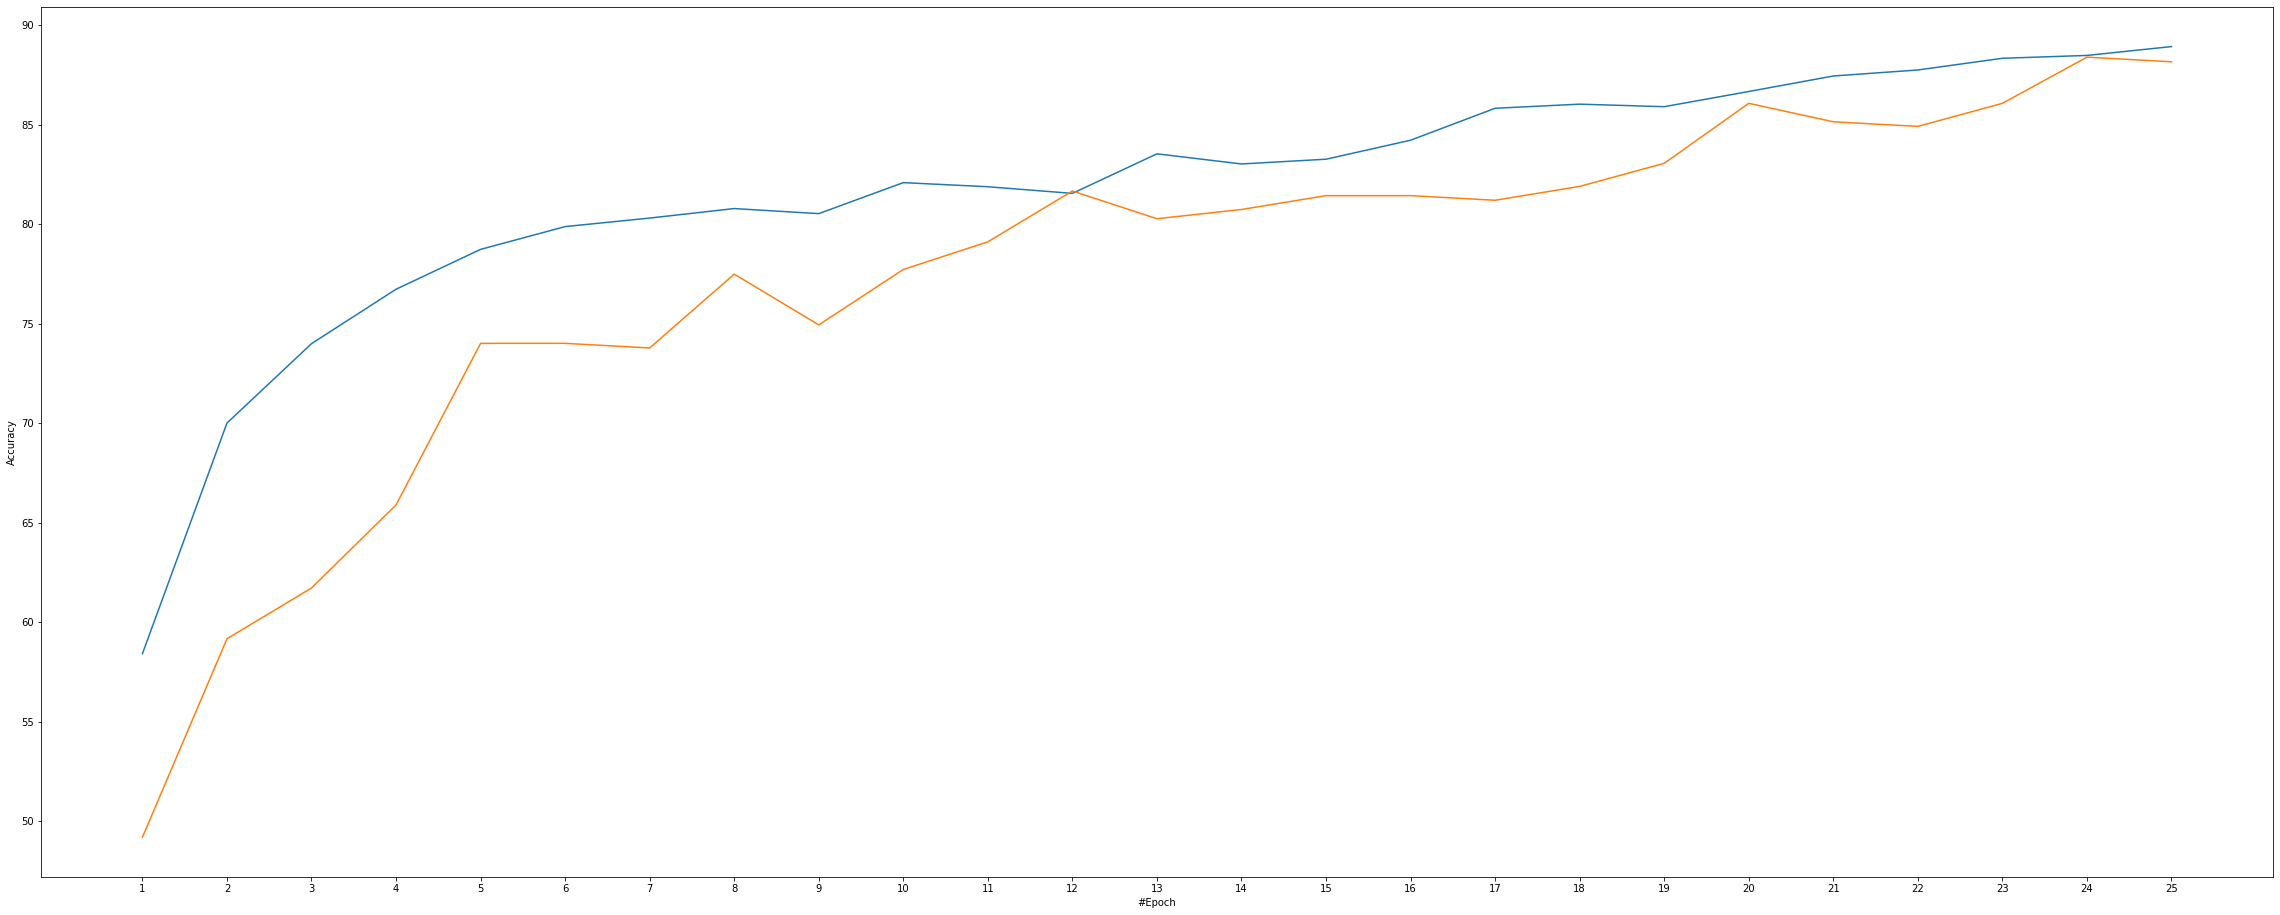

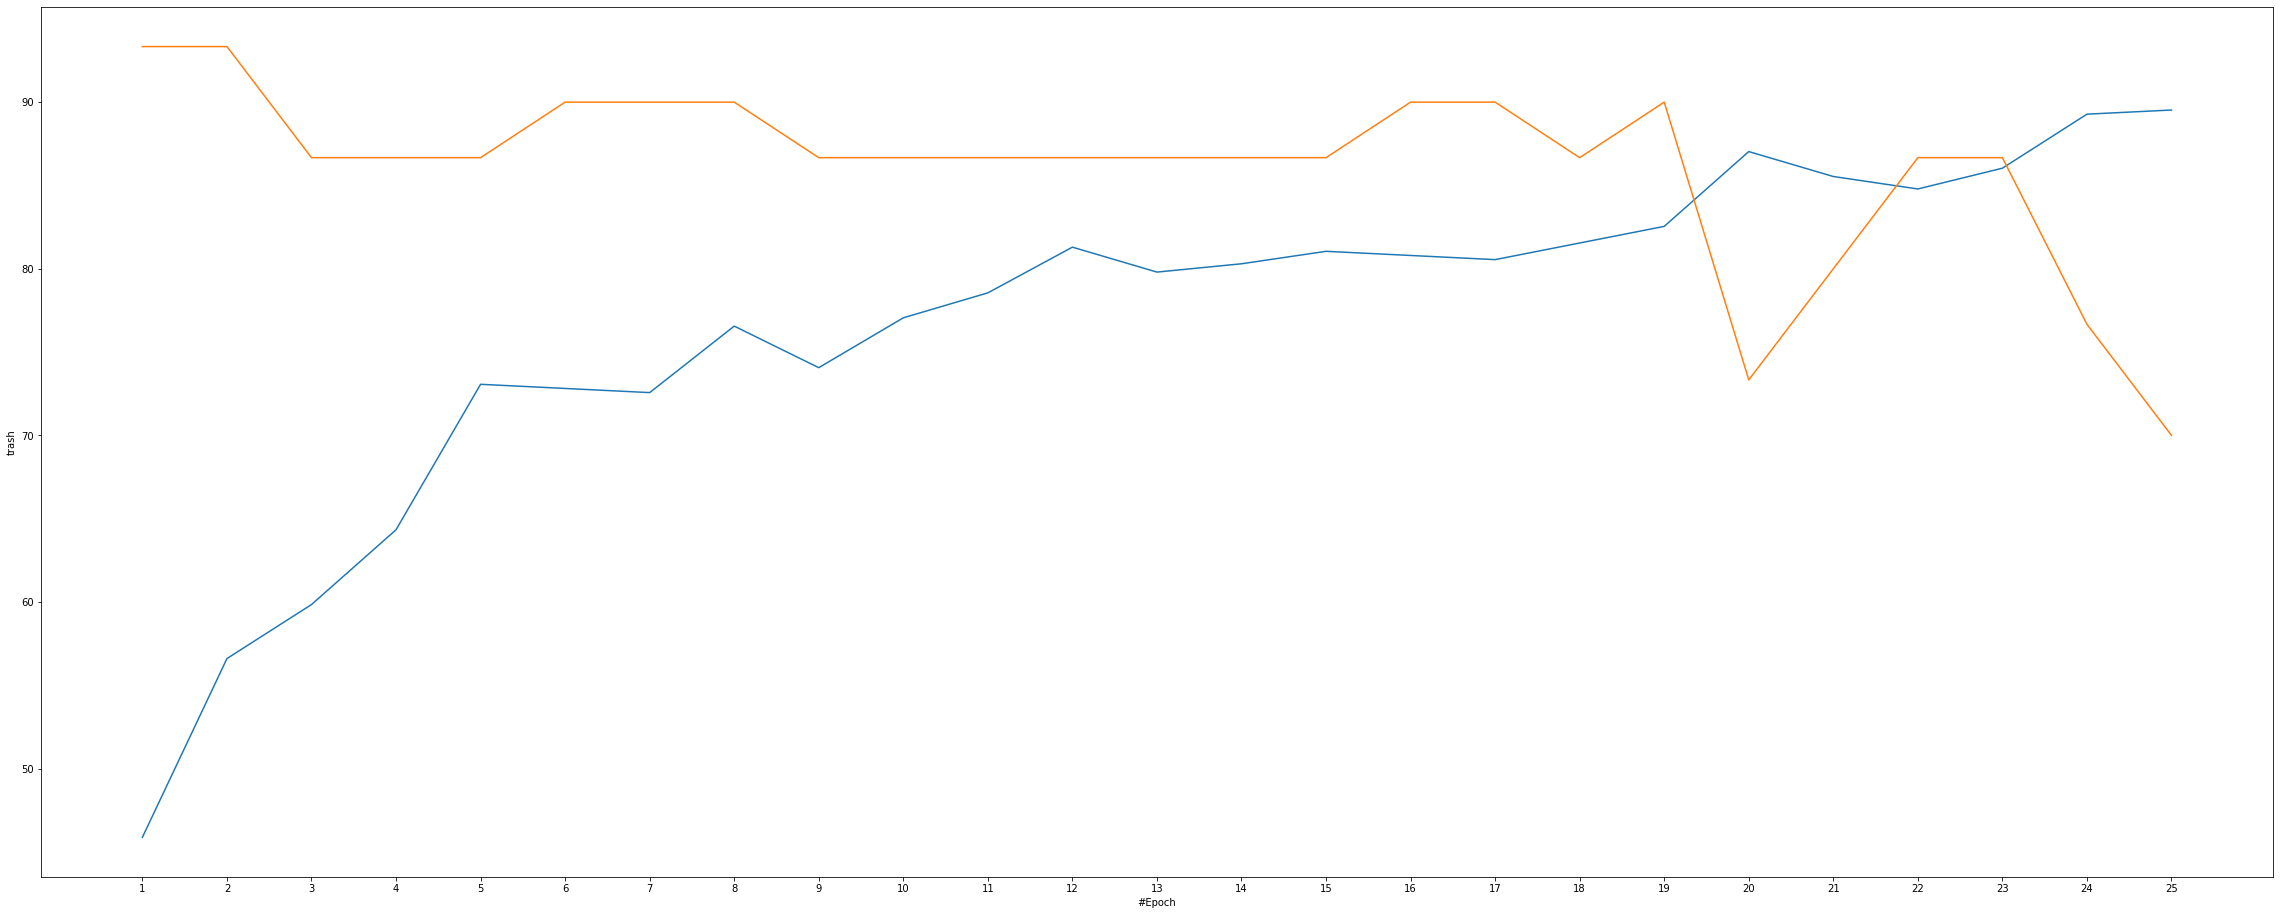

In [25]:
epochs = list(range(1, epochs + 1))
plt.figure(figsize=(40, 16))
plt.plot(epochs, train_loss_hist, label='Train loss')
plt.plot(epochs, valid_loss_hist, label='Valid loss')
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure(figsize=(40, 16))
plt.plot(epochs, train_acc_hist, label='Train accuracy')
plt.plot(epochs, valid_acc_hist, label='Valid accuracy')
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.show()

plt.figure(figsize=(40, 16))
for classname, accuracy in valid_class_acc_hist.items():
    plt.plot(epochs, accuracy, label='%s accuracy' % classname)
    plt.xlabel("#Epoch")
    plt.ylabel(classname)
    plt.xticks(epochs)
plt.show()



In [26]:
torch.save(model, 'model.pt')